In [17]:
import numpy as np
import pandas as pd


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from math import sqrt
from scipy import stats
from scipy.stats import norm


import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns
%matplotlib inline

def data_process(df_raw,remove_outlier = False,remove_hard_to_fit = False,linear_model = False):

	# Make a copy so the original dataframe will not be altered.
    df_processed = df_raw.copy()
    
    
	# Remove outliers.
    outlier_list_scatter = [524, 1299]
    outlier_list_hard_to_fit = [463, 31, 534, 1433, 739, 1159, 108, 1231, 971, 1424]
    outlier_list = outlier_list_scatter + outlier_list_hard_to_fi
    df_processed = df_processed.drop(outlier_list)

    
    ## Missing values
    
    # 259 LotFrontage  - replace missing value with 0 
    df_processed.LotFrontage = df_processed.LotFrontage.fillna(0)

    # 1369 Alley - replace with None
    df_processed.Alley = df_processed.Alley.fillna('None')

    # 8 MasVnrType and MasVnrArea - replace MasVnrType with None and MasVnrArea with 0
    df_processed.MasVnrType = df_processed.MasVnrType.fillna('None')
    df_processed.MasVnrArea = df_processed.MasVnrArea.fillna(0)

    # 37 basement: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2- replace with Nb
    df_processed.BsmtQual = df_processed.BsmtQual.fillna('Nb')
    df_processed.BsmtCond = df_processed.BsmtCond.fillna('Nb')
    df_processed.BsmtExposure = df_processed.BsmtExposure.fillna('Nb')
    df_processed.BsmtFinType1 = df_processed.BsmtFinType1.fillna('Nb')
    df_processed.BsmtFinType2 = df_processed.BsmtFinType2.fillna('Nb')
    df_processed.TotalBsmtSF = df_processed.TotalBsmtSF.fillna(0)
    

    # 690 FireplaceQu - replace with Nf
    df_processed.FireplaceQu = df_processed.FireplaceQu.fillna('Nf')

    # 81 Garage: GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond - replace with Ng and year with 0 
    df_processed.GarageType = df_processed.GarageType.fillna('Ng')
    df_processed.GarageFinish = df_processed.GarageFinish.fillna('Ng')
    df_processed.GarageQual = df_processed.GarageQual.fillna('Ng')
    df_processed.GarageCond = df_processed.GarageCond.fillna('Ng')
    df_processed.GarageYrBlt = df_processed.GarageYrBlt.fillna(0)

    # 1453 PoolQC - replace with Np
    df_processed.PoolQC = df_processed.PoolQC.fillna('Np')

    # 1179 Fence - replace with Nf
    df_processed.Fence = df_processed.Fence.fillna('Nf')

    # 1406 MiscFeature - replace with None    
    df_processed.MiscFeature = df_processed.MiscFeature.fillna('None')

    # 1 Electrical
    df_processed = df_processed[pd.notnull(df_processed.Electrical)]

    ## Combine columns and drop multicollinear columns 
    
    # combine bathroom quanlitity 
    df_processed['BsmtBath'] = df_processed.BsmtFullBath + df_processed.BsmtHalfBath * 0.5
    df_processed['Bath'] = df_processed.FullBath + df_processed.HalfBath * 0.5
    df_processed = df_processed.drop(['BsmtFullBath', 'BsmtHalfBath','FullBath','HalfBath'], axis=1)

    # drop TotalBsmtSF - multicollinearaty
    #df_processed = df_processed.drop(['TotalBsmtSF'], axis=1)

    # drop GrLivArea - multicollinearaty
    #df_processed = df_processed.drop(['GrLivArea'], axis=1)

    # drop GarageArea - higher correlation than GarageACars, results are better as well
    df_processed = df_processed.drop(['GarageArea'], axis=1) 
    
    
	# Feature Transformation - take the logarithm of the features.
    #Linear_Num_Cols = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'LotArea', 'GarageArea', 'TotRmsAbvGrd', 'TotalSF', 'BsmtFinSF1']
    df_processed.SalePrice = np.log(df_processed.SalePrice)
    df_processed.GrLivArea = np.log(df_processed.GrLivArea)
    df_processed.TotalBsmtSF = np.log(df_processed.TotalBsmtSF+1)
#     df_processed.LotArea = np.log(df_processed.LotArea) -- performance decreases
#     df_processed.GarageArea = np.log(df_processed.GarageArea)



	# Categorical Features Processsing

	# MSSubClass processing - MSSubClass 20-90 contains only duplicate information with HouseStyle and YearBuilt.
    df_processed['MSSubClass'] = df_processed['MSSubClass'].replace(['20','30','40','45','50','60','70','75','80','85'], '0')

    # Convert numerical to categorical. 
    df_processed[['MSSubClass','OverallQual','OverallCond']] = df_processed[['MSSubClass','OverallQual','OverallCond']].astype(str)

    #Get Dummies 
    df_processed = pd.get_dummies(df_processed, columns=df_processed.select_dtypes(include=['object']).columns, drop_first=True)

# #---Multiply features: 
#     df_processed["add_OverallGrade"] = df_processed["OverallQual"] * df_processed["OverallCond"]
#     df_processed["add_GarageGrade"] = df_processed["GarageQual"] * df_processed["GarageCond"]
#     df_processed["add_ExterGrade"] = df_processed["ExterQual"] * df_processed["ExterCond"]
#     df_processed["add_KitchenScore"] = df_processed["KitchenAbvGr"] * df_processed["KitchenQual"]
#     df_processed["add_FireplaceScore"] = df_processed["Fireplaces"] * df_processed["FireplaceQu"]
#     df_processed["add_GarageScore"] = df_processed["GarageArea"] * df_processed["GarageQual"]
#     df_processed["add_PoolScore"] = df_processed["PoolArea"] * df_processed["PoolQC"]
#     df_processed['add_GrLivArea*OvQual'] = df_processed['GrLivArea'] * df_processed['OverallQual']
#     df_processed['add_QualOverall*Exter*Kitch*Bsmt*Garage'] = df_processed['OverallQual'] * df_processed['ExterQual'] * df_processed['KitchenQual'] * df_processed['BsmtQual'] * df_processed['GarageQual']



    return df_processed

In [18]:
df_raw = pd.read_csv('train.csv',index_col=0)

df_regression = data_process(df_raw)

x_m = df_regression.drop(["SalePrice"], axis=1)
y_m = df_regression.loc[:,'SalePrice']
X_train, X_test, y_train, y_test = train_test_split(x_m, y_m, test_size=0.2, random_state=42)

ols = LinearRegression()
ols.fit(X_train, y_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print('-'*50)

print("R^2 for test  set: %f" %ols.score(X_test, y_test))

print('-'*50)
rms = sqrt(mean_squared_error(y_test, ols.predict(X_test)))
print("RMSE for test  set: %f" %rms)

R^2 for train set: 0.959474
--------------------------------------------------
R^2 for test  set: 0.904363
--------------------------------------------------
RMSE for test  set: 0.117039


 **Normality**

The mean of the errors is -0.0081
The standard deviation of the errors is 0.1103
Skewness: 0.250325
Kurtosis: 3.769718


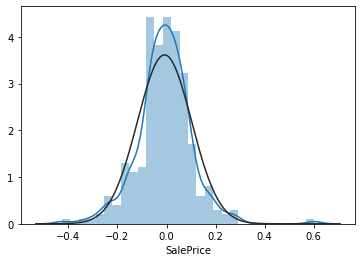

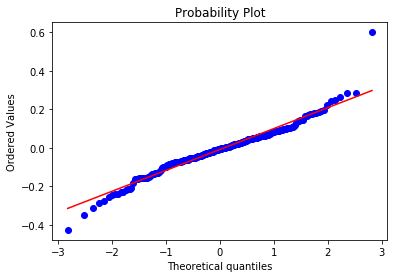

In [12]:
error = ols.predict(X_test) - y_test
print('The mean of the errors is %.4f' %np.mean(error))
print('The standard deviation of the errors is %.4f' % np.std(error))
print("Skewness: %f" % error.skew())
print("Kurtosis: %f" % error.kurt())
sns.distplot(error, fit=norm);
fig = plt.figure()
res = stats.probplot(error, plot=plt)


High Kurtosis means there are outliers for the model which are hard to fit in the model 

In [ ]:
# Drop the outliers 
error.sort_values(ascending=False)

**Constant Variance and Independent Errors**

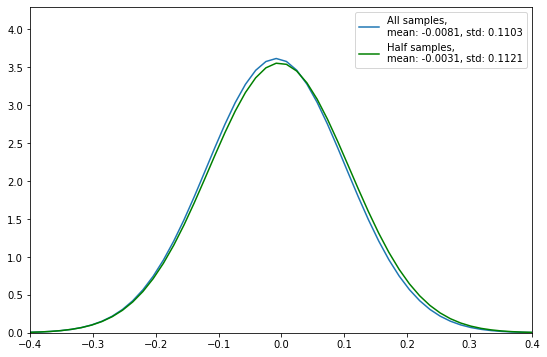

In [25]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


sub_error = error.sample(frac=0.5)

plt.figure(figsize=(9, 6))
plt.xlim(-0.4, 0.4)
plt.ylim(0, 4.3)

my_norm = stats.norm(np.mean(error), np.std(error)).pdf
label = 'All samples,\nmean: %.4f, std: %.4f' % (np.mean(error), np.std(error))
plt.plot(np.linspace(-0.4, 0.4), my_norm(np.linspace(-0.4, 0.4)), label=label)

my_norm = stats.norm(np.mean(sub_error), np.std(sub_error)).pdf
label = 'Half samples,\nmean: %.4f, std: %.4f' % (np.mean(sub_error), np.std(sub_error))
plt.plot(np.linspace(-0.4, 0.4), my_norm(np.linspace(-0.4, 0.4)), color='green', label=label)

plt.legend()
plt.show()